#Amazon Top 50 Bestselling Books 2009 - 2019
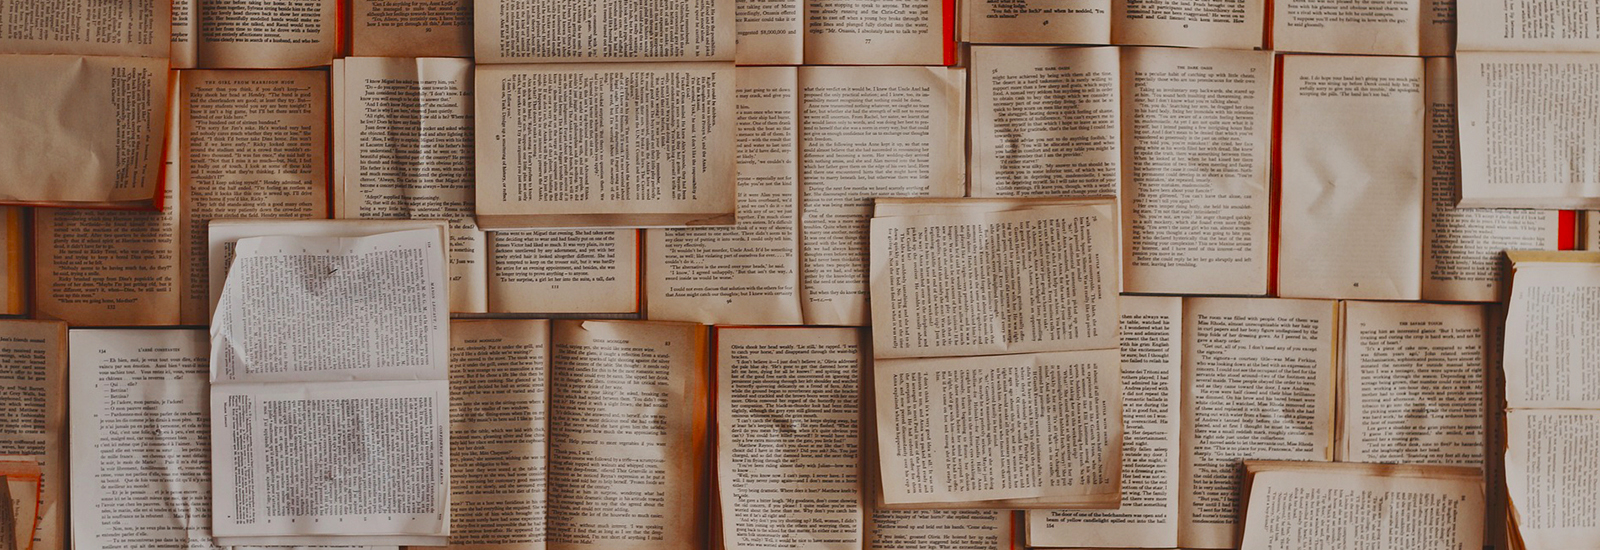

## Import Libraries

In [348]:
!pip install fuzzywuzzy
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from google.colab import drive
import fuzzywuzzy
from fuzzywuzzy import process
import collections
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import plotly.figure_factory as ff
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Dataset

In [ ]:
drive.mount("/content/drive")

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MLDA/bestsellers_with_categories.csv")
data2 = pd.read_csv("/content/drive/MyDrive/MLDA/bestsellers_with_categories.csv")
data.head()

**Features Descriptions**
- Name: Name of the book
- Author: Author of the book
- User Rating: Evaluation of the book
- Reviews: Number of reviews
- Price: Price of the book
- Year: Year of publication
- Genre: Genre of the book

## Preliminary Actions

**Getting informations about the Dataset**

In [ ]:
data.shape

The dataset contains 500 rows and 7 features.

**Null and unique value analysis**

In [ ]:
data.iloc[:,:].nunique()

In [ ]:
data.loc[:,['Name', 'Author']].duplicated().count()

In [ ]:
data.isnull().sum()

**Forming categorical columns**


In [ ]:
col_name_without_numeric_data = list(data.select_dtypes(exclude=('int', 'float')).columns)
print(f'Сolumns without numeric data: {", ".join(col_name_without_numeric_data)}.')

**Let's see the duplicates in the columns**


In [ ]:
for col in col_name_without_numeric_data:
    if data[col].duplicated().any() == True:
        print (f'Column {col} contains duplicates.')
    else:
        print (f'Column {col} does not contain duplicates.')

Check if the columns contains words in different case and extra spaces.



In [ ]:
# Check if spelling errors have been hit
for col in col_name_without_numeric_data:
    print(f'Before {col}: {len(set(data[col]))} After {col}: {len(set(data[col].str.title().str.strip()))}')

Indeed, there were typing errors in the Name column. Let's fix it.



In [ ]:
# Correct the errors
data.Name = data.Name.str.title().str.strip()
data2.Name=data2.Name.str.title().str.strip()

In [ ]:
# Check if the changes have passed
for col in col_name_without_numeric_data:
    print(f'Before {col}: {len(set(data[col]))} After {col}: {len(set(data[col].str.title().str.strip()))}')

**Let's check if there are the same author names but with different spellings.**



In [ ]:
# Check the column Autor
authors = data.Author.sort_values().unique()
authors

Names of authors George R. R. Martin, George R.R. Martin and J. K. Rowling, J.K. Rowling have different spellings although they are the same authors. Let's fix it.



In [ ]:
# Let's build a list of the most similar spellings
matches_author_name = fuzzywuzzy.process.extract('George R.R. Martin', authors, limit=5, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches_author_name

In [ ]:
# Replace the names of the authors with the correct ones
data = data.replace('George R. R. Martin', 'George R.R. Martin')
data = data.replace('J. K. Rowling', 'J.K. Rowling')
data2 = data2.replace('George R. R. Martin', 'George R.R. Martin')
data2 = data2.replace('J. K. Rowling', 'J.K. Rowling')

In [ ]:
# Check if the changes have passed
for col in col_name_without_numeric_data:
    print(f'Before {col}: {len(set(data[col]))} After {col}: {len(set(data[col].str.title().str.strip()))}')

Before Name: 350 After Name: 350
Before Author: 246 After Author: 246
Before Genre: 2 After Genre: 2


In [ ]:
# Check the column Genre
genre = data.Genre.unique()
genre

array(['Non Fiction', 'Fiction'], dtype=object)

**Everything is fine with genres.**



In [ ]:
# Check the column Year
years = list(data.Year.unique())
sorted(years)

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In addition, there may be duplicate rows in the data. Let's display the last 5 lines of the dataframe.



In [ ]:
# Let's display the last 5 lines of the dataframe
data.tail(4)


,Name,Author,User Rating,Reviews,Price,Year,Genre
546,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction
549,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2019,Non Fiction


**Remove duplicates and check how many books are left in the data**


In addition, it is worth nothing that there are duplicate rows in the data, but with different years. Let's remove duplicates. Let's leave the data without years for later analysis.

In [ ]:
# Delete the year column
del data['Year']

In [ ]:
data = data.drop_duplicates(keep='first')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 546
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         361 non-null    object 
 1   Author       361 non-null    object 
 2   User Rating  361 non-null    float64
 3   Reviews      361 non-null    int64  
 4   Price        361 non-null    int64  
 5   Genre        361 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 19.7+ KB


We received 11 more books than they actually have. Let's see why duplication occurs.



In [ ]:
# Let's count the number of each book in the data
count_books = collections.Counter(data.Name.tolist())
print(count_books.most_common(11))

[('The Help', 3), ('Gone Girl', 2), ("Quiet: The Power Of Introverts In A World That Can'T Stop Talking", 2), ('The 5 Love Languages: The Secret To Love That Lasts', 2), ('The 7 Habits Of Highly Effective People: Powerful Lessons In Personal Change', 2), ('The Fault In Our Stars', 2), ('The Girl On The Train', 2), ('The Immortal Life Of Henrietta Lacks', 2), ('To Kill A Mockingbird', 2), ('Unbroken: A World War Ii Story Of Survival, Resilience, And Redemption', 2), ('10-Day Green Smoothie Cleanse', 1)]


Сheck with the example of a book The Help.



In [ ]:
# Display information on the book The Help
data[data['Name'] == 'The Help']

,Name,Author,User Rating,Reviews,Price,Genre
402,The Help,Kathryn Stockett,4.8,13871,6,Fiction
404,The Help,Kathryn Stockett,4.8,13871,8,Fiction
405,The Help,Kathryn Stockett,4.8,13871,7,Fiction


Records are duplicated by price. Apparently, in different years the book costs differently, which is quite logical taking into account inflation, demand, etc. Let's leave only the last entries.

In [ ]:
# Drop duplicates
data = data.drop_duplicates(subset='Name', keep='last')
data

,Name,Author,User Rating,Reviews,Price,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,Fiction
2,12 Rules For Life: An Antidote To Chaos,Jordan B. Peterson,4.7,18979,15,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,Non Fiction
...,...,...,...,...,...,...
538,Winter Of The World: Book Two Of The Century T...,Ken Follett,4.5,10760,15,Fiction
539,Women Food And God: An Unexpected Path To Almo...,Geneen Roth,4.2,1302,11,Non Fiction
540,Wonder,R. J. Palacio,4.8,21625,9,Fiction
545,Wrecking Ball (Diary Of A Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,Fiction


Thus, the data contains 350 different books written by 246 authors. All books are presented in two categories (Non Fiction, Fiction).

## General Analysis


**Quantitative and qualitative features**
- Qualitative Variables: `Name`, `Author`, `Genre`
- Quantitative Variables: `User Rating`, `Review`, `Price`, `Year`

**Map qualitative features into quantitative ones**

Since we only have few values for the Genre  we can map the values of this feature into numerical ones.

In [ ]:
#data['Genre'] = pd.factorize(data['Genre'])[0]


**Check which column are correlated**


<ipython-input-304-6cfbe0d7fc7a>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



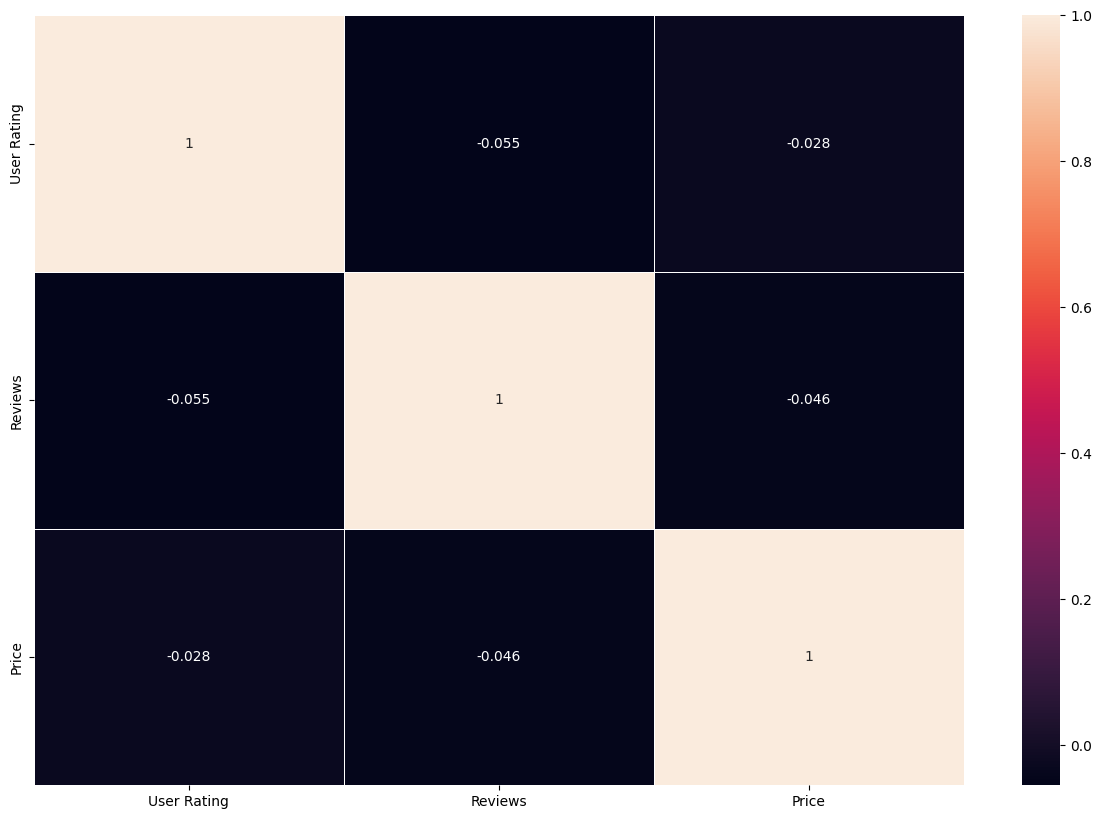

In [ ]:
corr_df = data.corr()

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_df, annot=True, linewidths=.5, ax=ax)
plt.show()

Get through the use of the describe() function stats about quantitative features



In [ ]:
data.describe()

,User Rating,Reviews,Price
count,350.000000,350.000000,350.000000
mean,4.608857,9804.605714,12.925714
std,0.226993,10885.017686,10.003161
min,3.300000,37.000000,0.000000
25%,4.500000,3435.250000,7.250000
50%,4.600000,6328.000000,11.000000
75%,4.800000,11510.250000,16.000000
max,4.900000,87841.000000,105.000000


**Check the general Characteristics:**

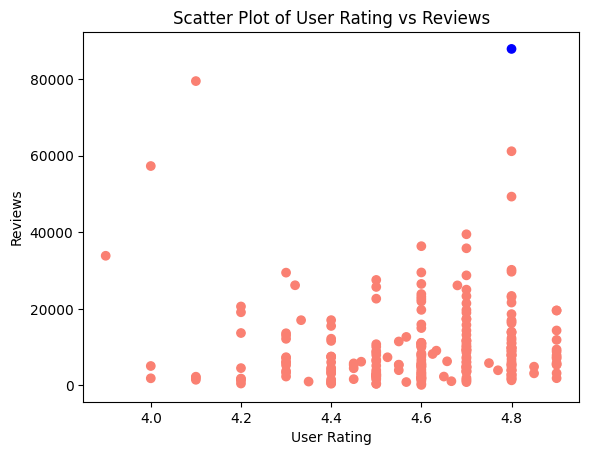

In [ ]:

# Find the maximum value of the 'Reviews' column
max_reviews = data['Reviews'].max()

# Create a new column that assigns a different color to the rows with the highest reviews
data['Color'] = np.where(data['Reviews'] == max_reviews, 'blue', 'salmon')

# Group data by 'Author' and calculate the mean of 'User Rating' and 'Reviews'
grouped_data = data.groupby('Author').agg({'User Rating': 'mean', 'Reviews': 'mean', 'Color': 'first'})

# Create scatter plot
plt.scatter(grouped_data['User Rating'], grouped_data['Reviews'], color=grouped_data['Color'])

# Add axis labels and title
plt.xlabel("User Rating")
plt.ylabel("Reviews")
plt.title("Scatter Plot of User Rating vs Reviews")

# Display the plot
plt.show()

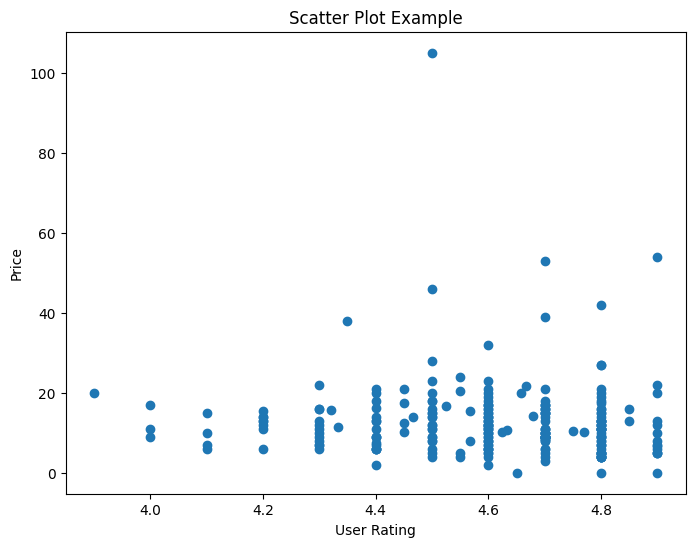

In [ ]:
plt.figure(figsize=(8,6)) # adjust the size to your preference

# Create scatter plot
plt.scatter(data.groupby('Author')['User Rating'].mean(),data.groupby('Author').Price.mean())

# Add axis labels and title
plt.xlabel("User Rating")
plt.ylabel("Price")
plt.title("Scatter Plot Example")

# Display the plot
plt.show()

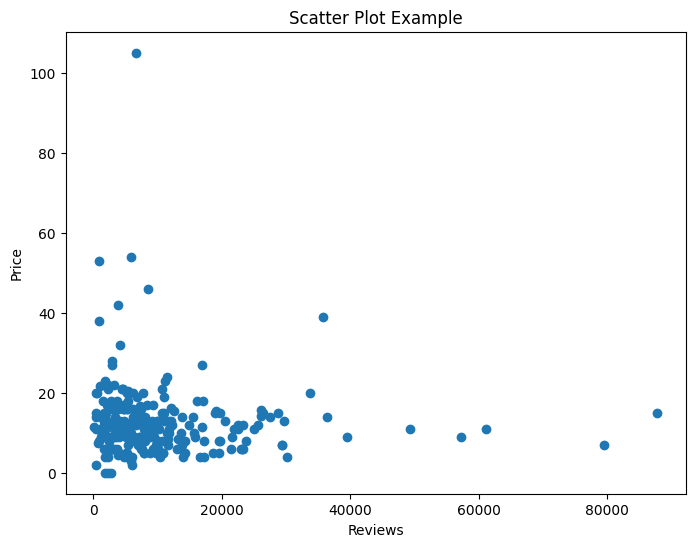

In [ ]:
plt.figure(figsize=(8,6)) # adjust the size to your preference

# Create scatter plot
plt.scatter(data.groupby('Author')['Reviews'].mean(),data.groupby('Author').Price.mean())

# Add axis labels and title
plt.xlabel("Reviews")
plt.ylabel("Price")
plt.title("Scatter Plot Example")

# Display the plot
plt.show()

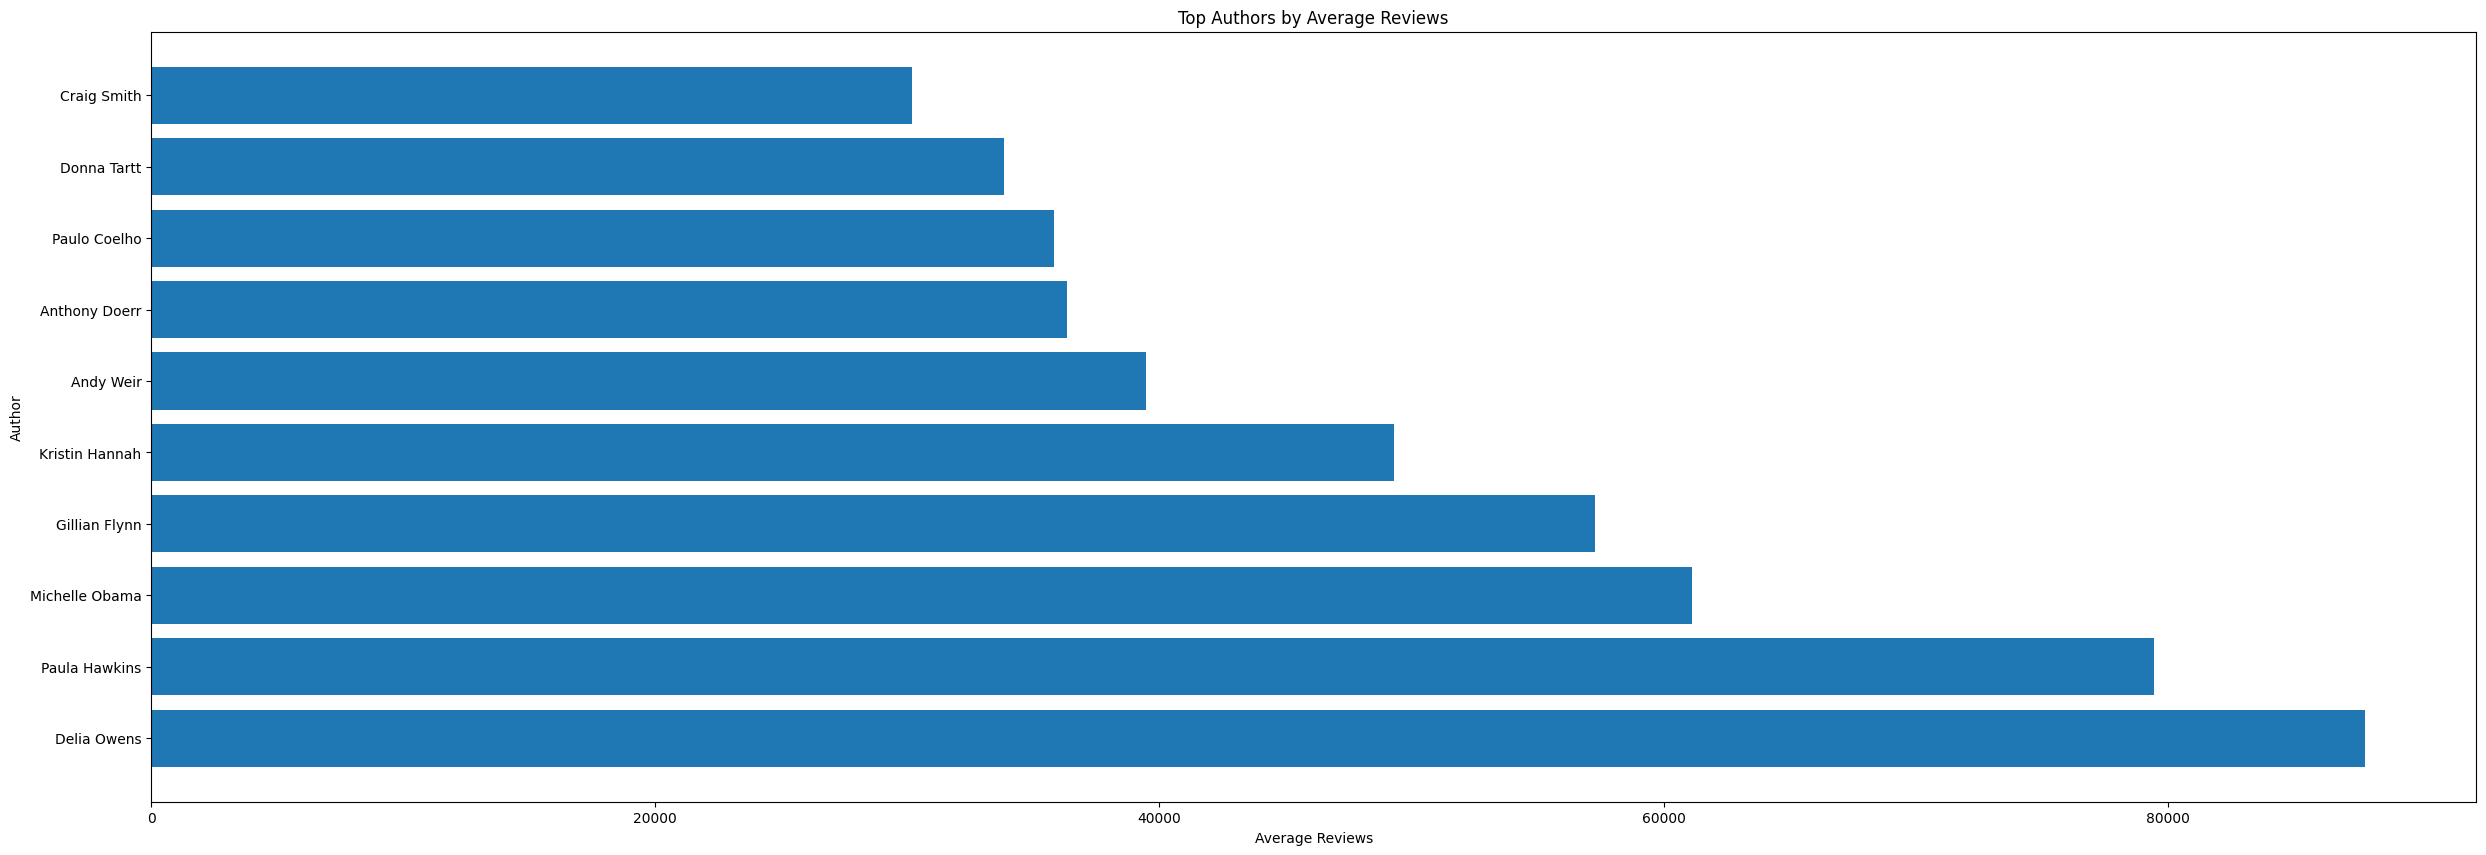

In [ ]:
grouped_data=data.groupby('Author')[['Reviews', 'User Rating']].mean().sort_values(by=['Reviews', 'User Rating'], ascending=False).head(10)

# Create a horizontal bar chart

fig, ax = plt.subplots(figsize=(30,10))
ax.barh(grouped_data.index, grouped_data['Reviews'])

# Add labels and title
ax.set_xlabel('Average Reviews')
ax.set_ylabel('Author')
ax.set_title('Top Authors by Average Reviews')

plt.show()

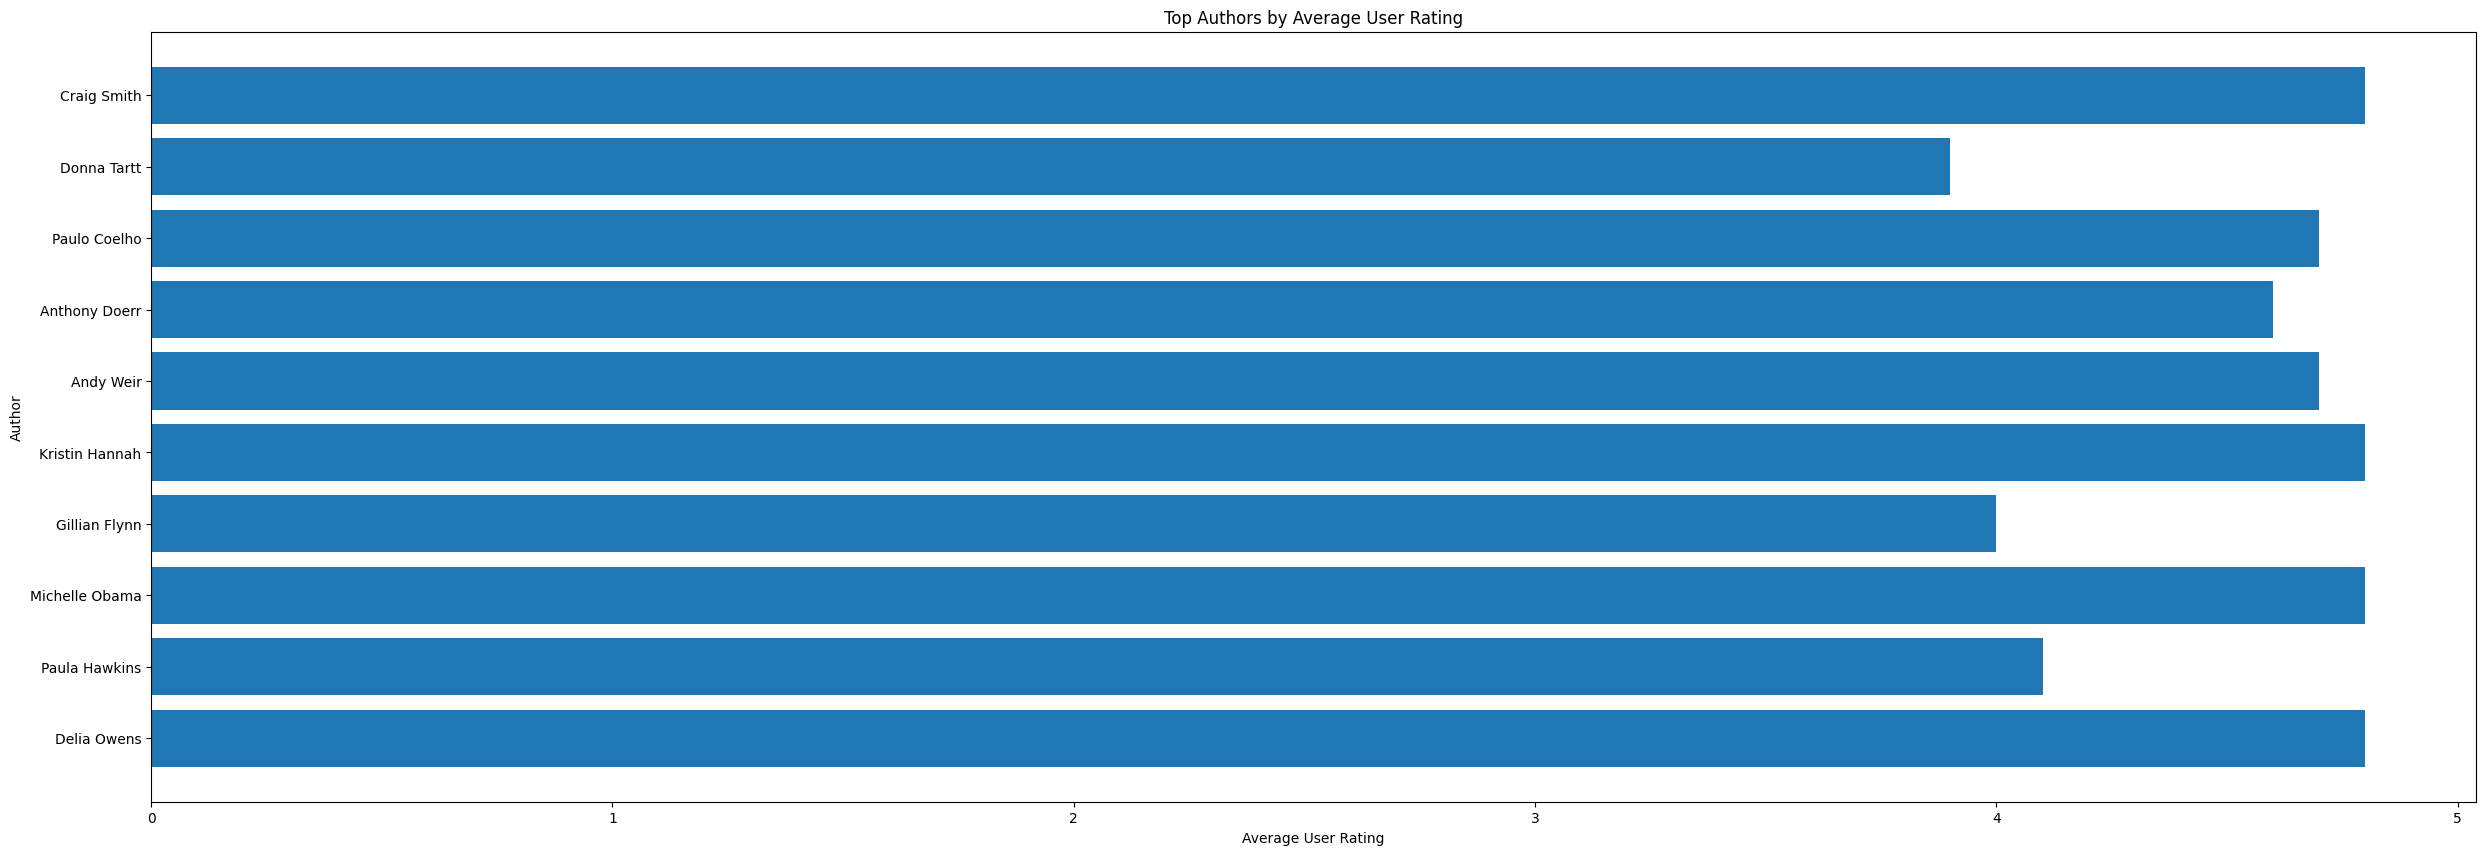

In [ ]:
grouped_data=data.groupby('Author')[['Reviews', 'User Rating']].mean().sort_values(by=['Reviews', 'User Rating'], ascending=False).head(10)

# Create a horizontal bar chart

fig, ax = plt.subplots(figsize=(30,10))
ax.barh(grouped_data.index, grouped_data['User Rating'])

# Add labels and title
ax.set_xlabel('Average User Rating')
ax.set_ylabel('Author')
ax.set_title('Top Authors by Average User Rating')

plt.show()

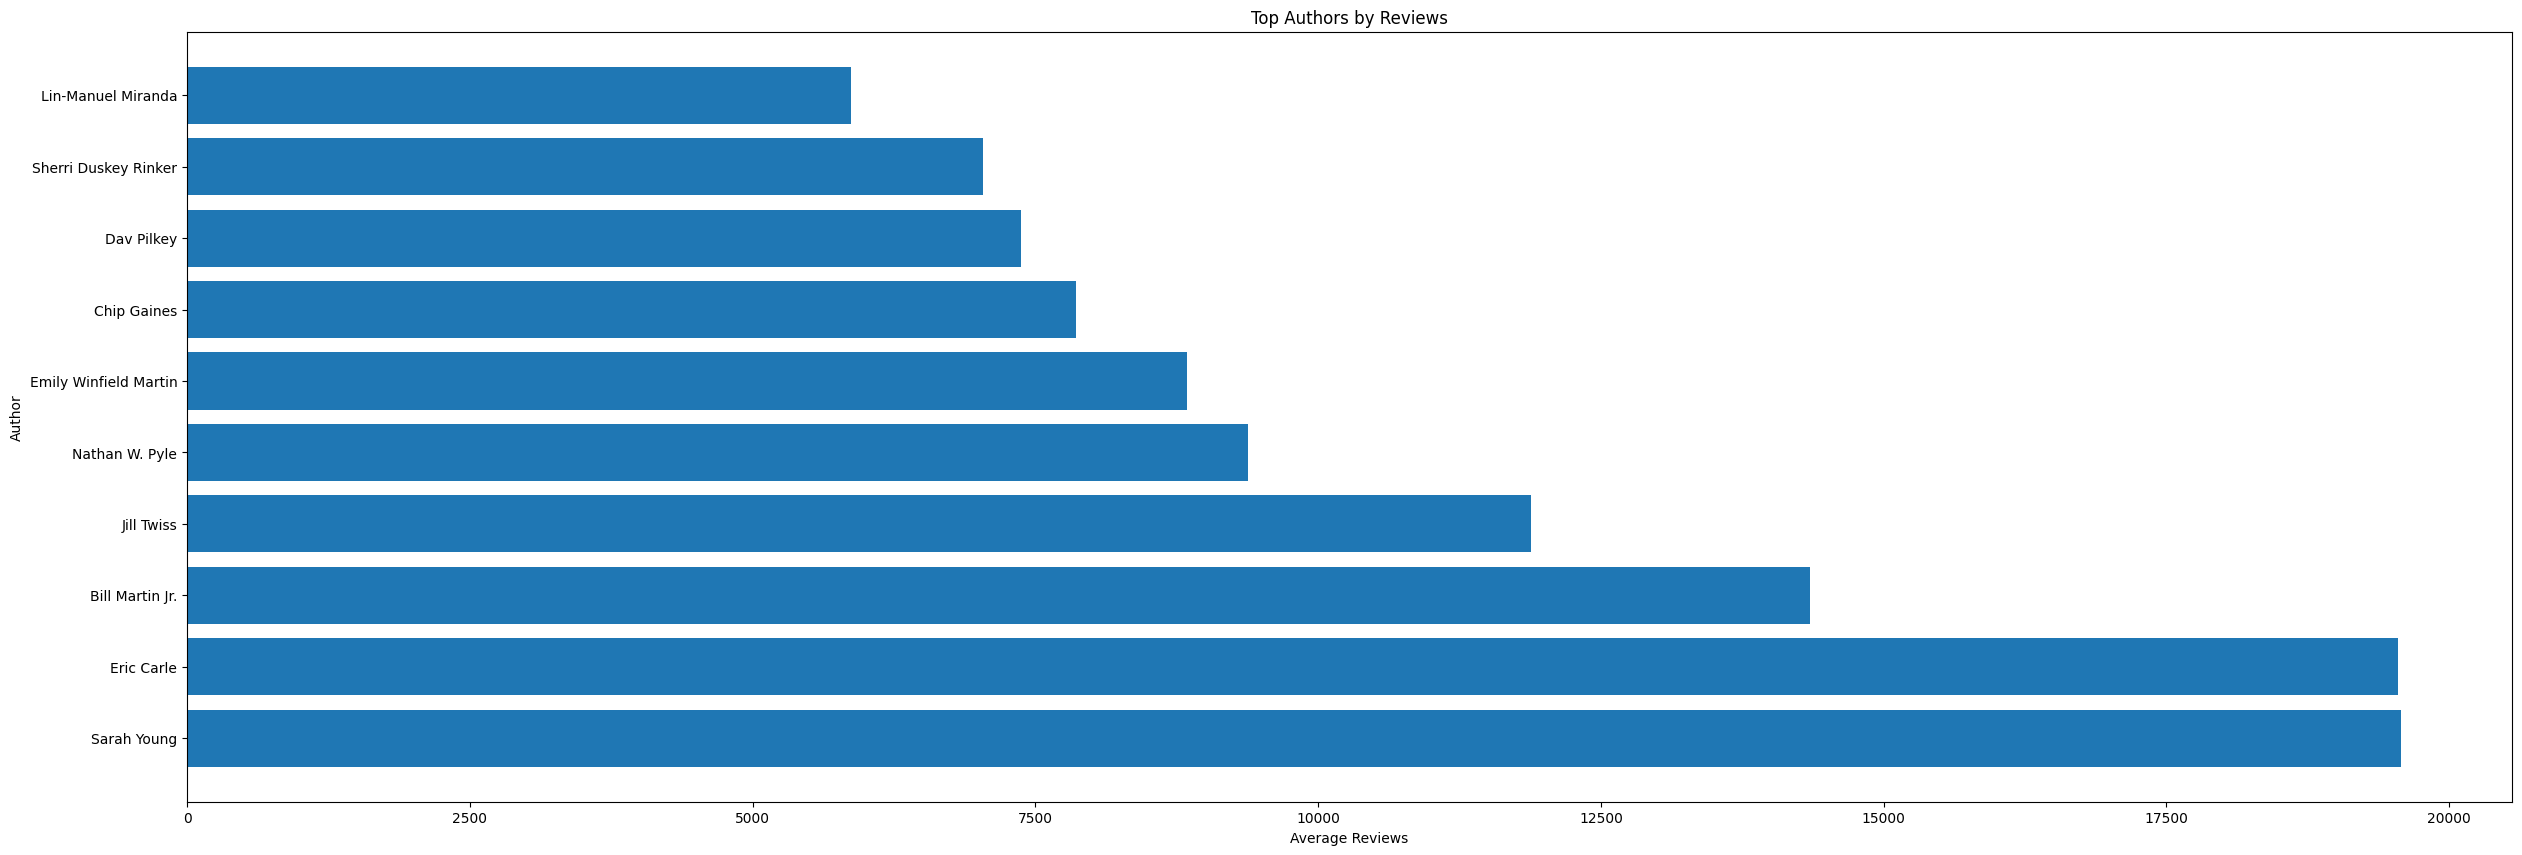

In [ ]:
grouped_data=data.groupby('Author')[['Reviews', 'User Rating']].mean().sort_values(by=['User Rating', 'Reviews'], ascending=False).head(10)

# Create a horizontal bar chart

fig, ax = plt.subplots(figsize=(30,10))
ax.barh(grouped_data.index, grouped_data['Reviews'])

# Add labels and title
ax.set_xlabel('Average Reviews')
ax.set_ylabel('Author')
ax.set_title('Top Authors by Reviews')

plt.show()

In this section, we will analyze categorical data and answer the following questions:

- Which author's books receive the highest average rating (top authors).
- Which author has written the most bestsellers (top authors).
- Which genres become bestsellers more often.
- Which book has the most reviews (top books).

Let's create new dataframes based on the average rating of authors, the number of books written by authors, the number of reviews for books and the number of books by genre. We visualize the received information.

In [ ]:
# We take all authors with the highest average rating
top_13_autors = data.groupby('Author')[['User Rating', 'Reviews']].mean()\
                                                              .sort_values(['Reviews'] ,ascending=False)\
                                                              .head(10)\
                                                              .reset_index()
# We take the authors who have written the most bestsellers
number_of_books_written = data.groupby('Author')[['Name']].count()\
                                                                 .sort_values('Name', ascending=False)\
                                                                 .head(10)\
                                                                 .reset_index()

# We take books with the number of reviews
books_with_the_number_of_reviews = data.groupby('Name')[['Reviews']].sum()\
                                                                           .sort_values('Reviews', ascending=False)\
                                                                           .head(5)\
                                                                           .reset_index()

# We take the number of books by genre
number_of_books_by_genre = data.groupby('Genre')[['Name']].count()\
                                                                 .sort_values('Name', ascending=False)\
                                                                 .head(10)\
                                                                 .reset_index()
# Let's set the visualization parameters
fig_1 = make_subplots(rows=1, cols=1, subplot_titles=("")) # Let's set the number of rows and columns


# Setting table parameters
fig_1.add_trace(go.Table(columnorder = [1,2],
                         columnwidth = [20,10],
                         header=dict(values=top_13_autors.columns, 
                                     line_color='darkslategray',
                                     fill_color='salmon',
                                     height=30),
                         cells=dict(values=[top_13_autors['Author'],
                                    top_13_autors['User Rating'],
                                    top_13_autors['Reviews']], 
                                    line_color='darkslategray',
                                    fill_color='White')))

# Setting the parameters of the chart when displaying
fig_1.update_layout(showlegend=False, 
                    title_text='Top 13 best authors', 
                    title_font_size=16, 
                    title_font_family='Arial', 
                    title_x=0.5,
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the graph
fig_1.show()

# Let's set the visualization parameters
fig_2 = make_subplots(rows=1, cols=2,
                      specs=[[{'type': 'xy'}, {"type": "xy"}]],
                      subplot_titles=("Top 10 authors by number of bestsellers", 
                                      "Top 5 books by number of reviews"))

# Setting Bar parameters
fig_2.add_trace(go.Bar(x=number_of_books_written['Author'], 
                       y=number_of_books_written['Name'],
                       name ='Count books',
                       marker_color=['#ff6666','#f76e6e', '#f07575', '#e87d7d', '#e08585',
                                     '#d98c8c', '#d19494', '#c99c9c', '#c2a3a3', '#baabab']),
                       row=1, col=1)

# Setting Bar parameters
fig_2.add_trace(go.Bar(x=books_with_the_number_of_reviews['Name'], 
                       y=books_with_the_number_of_reviews['Reviews'],
                       marker_color=['#ff6666','#f47171', '#e87d7d', '#dd8888', '#d19494'],
                       name ='Reviews'),
                       row=1, col=2)

# Setting the parameters of the chart when displaying
fig_2.update_traces(marker_line_color='Gray',
                    marker_line_width=1)

# Setting the parameters of the chart when displaying
fig_2.update_layout(showlegend=False, 
                    plot_bgcolor='rgba(0,0,0,0)',
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the graph
fig_2.show()

# Let's set the visualization parameters
fig_3 = make_subplots(rows=1, cols=1,
                      specs=[[{'type': 'domain'}]],
                      subplot_titles=(""))

# Setting Pie parameters
fig_3.add_trace(go.Pie(values=number_of_books_by_genre['Name'],
                       title='Genre',
                       labels=['Non Fiction', 'Fiction'],
                       textinfo='label+percent',
                       insidetextorientation='radial',
                       hole=0.3,
                       marker=dict(colors=['salmon','Gray'], 
                                   line_color='Gray', 
                                   line_width=1),
                       textfont={'color': '#000000', 'size': 12},
                       textfont_size=12))

# Setting the parameters of the chart when displaying
fig_3.update_layout(margin_t=30, 
                    showlegend=False, 
                    title_text='Count of books genre', 
                    title_x=0.5, 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the graph
fig_3.show()


- The following 13 authors have the highest rating: Nathan W. Pyle, Patrick Thorpe, Eric Carle, Emily Winfield Martin, Chip Gaines, Jill Twiss, Rush Limbaugh, Sherri Duskey Rinker, Alice Schertle, Pete Souza, Sarah Young, Lin-Manuel Miranda, Bill Martin Jr., Dav Pilkey. The average rating for their works was 4.9. When buying a new book, you should pay attention to these authors.

- Authors who have written more bestsellers: Jeff Kinney - 12 books, Rick Riordan - 10 books, J.K. Rowling - 8 books, Stephenie Meyer - 7 books, Dav Pilkey - 6 books, Bill O'Reilly - 6 books, John Grisham - 5 books, E L James - 5 books, Suzanne Collins - 5 books, Charlaine Harris - 4 books. These authors always have something to read.

- Books with the most reviews: Where The Crawdads Sing - 87841 Reviews, The Girl On The Train - 79446 Reviews, Becoming - 61133 Reviews, Gone Girl - 57271 Reviews, The Fault In Our Stars - 50482 Reviews. It's definitely worth reading the book Where The Crawdads Sing, it's not for nothing that it is the most talked about.

- Non-fiction is more likely to become a bestseller. Later we will find out how users relate to these genres.

Non-Fiction User rating vs Fiction User Rating

In [ ]:
# Raggruppa i dati per genere e calcola la media del rating utente
ratings_by_genre = data.groupby('Genre')['User Rating'].mean()

# Crea il grafico a barre
ratings_by_genre.plot(kind='bar')

# Aggiungi etichette e titolo
plt.xlabel('Genre')
plt.ylabel('User Rating')
plt.title('Average User Rating by Genre')

# Mostra il grafico
plt.show()

Let's look at the measures of the central trend that characterize the distribution of numerical values in the data. We render a box-plot for each numeric variable

In [ ]:
# Displaying measures of the central trend
data.describe()

In [ ]:
# Let's set the visualization parameters
fig_4 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
fig_4.add_trace(go.Box(x=data['User Rating'], 
                       name='User Rating'))

# Setting the parameters of the Box when displaying
fig_4.update_traces(marker_color='salmon')

# Setting the parameters of the Box when displaying
fig_4.update_layout(showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Box
fig_4.show()

# Let's set the visualization parameters
fig_5 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
fig_5.add_trace(go.Box(x=data['Reviews'], 
                       name='Reviews'))

# Setting the parameters of the Box when displaying
fig_5.update_traces(marker_color='salmon')

# Setting the parameters of the Box when displaying
fig_5.update_layout(showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Box
fig_5.show()

# Let's set the visualization parameters
fig_6 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
fig_6.add_trace(go.Box(x=data['Price'], 
                       name='Price'))

# Setting the parameters of the Box when displaying
fig_6.update_traces(marker_color='salmon')

# Setting the parameters of the Box when displaying
fig_6.update_layout(showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Box
fig_6.show()

By analyzing the numeric data, it is established:

- User Rating:

  Data is not distributed normally. Asymmetry is observed.
  Average and median book ratings are 4.6.
  There are outliers in the data. There are a small number of books in the data 
  below the 4.1 rating.

- Reviews:

  Data is not distributed normally. Asymmetry is observed.
  The data has a wide range.
  There are outliers in the data. There are a small number of books receiving 
  reviews well above the 75 percentile.

- Price:

  Data is not distributed normally. Asymmetry is observed.
  There are books that cost much higher than the average, as well as books with 
  a cost of 0, which is strange.There are books that cost much higher than the 
  average, as well as books with a cost of 0, which is strange. Either the book 
  is given for free or this error.

###Trend Over **Years**

1. Trend of Reviews for each year

In [ ]:
X = sorted(list(data2.Year.unique()))  # Sort the years in ascending order
X_axis = np.arange(len(X))
plt.xticks(X_axis, X)
plt.plot(X_axis,data2.groupby('Year')['Reviews'].sum(),color='salmon')
plt.xlabel("Year")
plt.grid()
plt.ylabel("Number of Revies")
plt.title("Number of Reviews Written Each Year")


2. Trend of User Rating for each year

In [ ]:
X = sorted(list(data2.Year.unique()))  # Sort the years in ascending order
X_axis = np.arange(len(X))
plt.xticks(X_axis, X)
plt.plot(X_axis,data2.groupby('Year')['User Rating'].mean(),color='salmon')
plt.xlabel("Year")
plt.grid()
plt.ylabel("Mean of User Rating")
plt.title("Mean of User Rating for Each Year")

3. Trend of Genre for each year

In [ ]:

fiction_data = data2.loc[data2.Genre == "Fiction"]
nonfiction_data = data2.loc[data2.Genre == "Non Fiction"]

X = sorted(list(data2.Year.unique()))  # Sort the years in ascending order

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, fiction_data.groupby('Year')['Genre'].count().loc[X], 0.4, label = 'Fiction',color='grey')
plt.bar(X_axis + 0.2, nonfiction_data.groupby('Year')['Genre'].count().loc[X], 0.4, label = 'Non Fiction',color='salmon')

plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("Number of Books")
plt.title("Number of Books Published Each Year")
plt.legend()
plt.show()

###Which Words make a Bestseller Title?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english')
bag_of_words = vect.fit_transform(data2['Name'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
d = {}
for w, c in words_freq[:20]:
    d[w] = c
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.grid(alpha=0.3)
plt.bar(list(d.keys()), list(d.values()), label="Occurency of words",color='salmon')
plt.xticks(list(d.keys()), list(d.keys()), rotation=70)
plt.title('Most used words')
plt.xlabel('Word')
plt.ylabel('Occurency of the word')
plt.legend()
plt.show()

###Most Used Words per Year

In [ ]:
# Creo delle liste per storare i risultati
x = [] # Years
y = [] # Counter
l = [] # Parola più utilizzata
def mfw(df):
    bag_of_words = vect.fit_transform(pd.DataFrame(df)['Name'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    d = {}
    d['Year'] = df['Year'].values[0]
    d['mfw'] = words_freq[0][0]
    d['count'] = words_freq[0][1]
    x.append(str(df['Year'].values[0]))
    y.append(words_freq[0][1])
    l.append(words_freq[0][0])
    return (x, y, l)
c = data2.groupby(data2.Year)['Year'].count().values.tolist()
data2.groupby(data2.Year).apply(mfw)

fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.grid(alpha=0.3)
ax.bar(x, c, width = 0.9, label="Book Released", color='salmon', alpha=.7)
ax.bar(x, y, width = 0.9, label="Occurencies", color='#1f77b4')
for i in range(len(x)):
    plt.annotate(str(l[i])+'\n'+str(((y[i]*100)/c[i]).round(1))+'%', xy=(x[i],y[i]), ha='center', va='bottom', c='#1f77b4')
plt.title('Most used words in plots per decade')
plt.xlabel('Years')
plt.ylabel('Occurencies of the word')
plt.legend()
plt.show()

#Machine Learning


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder


**Data Normalization**

In [ ]:
le = LabelEncoder()

data2['Genre'] = le.fit_transform(data2['Genre'])

avg_rating = data2['User Rating'].mean()

# create a new column with user rating > average
data2['User Rating'] = data2['User Rating'].apply(lambda x: 1 if x > avg_rating else 0)

# print the updated dataset
data2.head()
X = data2.drop(['Name', 'Author','User Rating'], axis=1)
y = data2['User Rating']


## fare nuova colonna di user rating 1 sopra la media 0 sotto la media
## predizione di classificazione usando solo quantitative 

In [ ]:
X.describe


**Data splitting**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Decision Tree

**Tuning**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# define the Decision Tree model
dtc = DecisionTreeClassifier()

# define the parameters to explore
parameters = {'max_depth': [3, 5, 7, 10, None],
              'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 2, 4, 8],
              }

# define the GridSearchCV
grid_search = GridSearchCV(estimator=dtc, param_grid=parameters, cv=5)

# train the GridSearchCV
grid_search.fit(X_train, y_train)

# print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print(grid_search.best_estimator_)


**User Rating Prediction**

In [ ]:
decTree = DecisionTreeClassifier(max_depth=7)

decTree.fit(X_train, y_train)
predictions = decTree.predict(X_test)

In [ ]:
results_d= pd.DataFrame({'Current Values': y_test, 'Predicted Values': predictions})
print(results_d)

**metrice**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# compute accuracy, precision, recall, and AUC scores
accuracy_dec = accuracy_score(y_test, predictions)
precision_dec = precision_score(y_test, predictions)
recall_dec= recall_score(y_test, predictions)
auc_dec= roc_auc_score(y_test, predictions)

# print the scores
print('Accuracy:', accuracy_dec)
print('Precision:', precision_dec)
print('Recall:', recall_dec)
print('AUC:', auc_dec)


**Confusion Matrix**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

In [ ]:
plt.figure(figsize=(9,9))

labels = ['Over Average: 1', 'Under Average: 0']

con_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(con_matrix, cmap='YlGnBu', annot=True, cbar=False, square=True, 
           xticklabels=labels, 
           yticklabels=labels)

plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Decision Tree Classifier Confusion Matrix', fontsize=20)
plt.show()

**Decision Tree without GrindSearchCV**

In [ ]:
decTree = DecisionTreeClassifier()

decTree.fit(X_train, y_train)
predictions = decTree.predict(X_test)

In [ ]:
results_d= pd.DataFrame({'Current Values': y_test, 'Predicted Values': predictions})
print(results_d)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# compute accuracy, precision, recall, and AUC scores
accuracy_dec_d = accuracy_score(y_test, predictions)
precision_dec_d = precision_score(y_test, predictions)
recall_dec_d = recall_score(y_test, predictions)
auc_dec_d= roc_auc_score(y_test, predictions)

# print the scores
print('Accuracy:', accuracy_dec_d)
print('Precision:', precision_dec_d)
print('Recall:', recall_dec_d)
print('AUC:', auc_dec_d)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

In [ ]:
plt.figure(figsize=(9,9))

labels = ['Over Average: 1', 'Under Average: 0']

con_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(con_matrix, cmap='YlGnBu', annot=True, cbar=False, square=True, 
           xticklabels=labels, 
           yticklabels=labels)

plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Decision Tree Classifier Confusion Matrix', fontsize=20)
plt.show()

## KNN

**Tuning:Find best K and metric and weights**

- **n_neighbors**: Number of neighbors we are going to check to determine whether our sample x is in class A or B.

- **metric**: There are four ways to calculate the distance measure between the data point and its nearest neighbor: Euclidean distance, Manhattan distance, Hamming distance, and Minkowski distance. Basically we change the method used to calculate the distance between the point and the neighbors selected.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = { 
    'n_neighbors' : [5,7,9,11,13,15],
    'metric' : ['minkowski','euclidean','manhattan'],
    'weights': ['uniform', 'distance'],
}

knn = KNeighborsClassifier()

model2 = GridSearchCV(knn, params, cv=5)
model2.fit(X_train, y_train)

print(model2.best_params_)
best_n_estimator = int(model2.best_params_['n_neighbors'])


**User ratig Prediction**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=best_n_estimator, metric=str(model2.best_params_['metric']), weights=str(model2.best_params_['weights']))
neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
results_d = pd.DataFrame({'Actual Values': y_test, 'Predicted Values': predictions})
print(results_d)


**Metric**

In [ ]:
# compute accuracy, precision, recall, and AUC scores
accuracy_knn = accuracy_score(y_test, predictions)
precision_knn = precision_score(y_test, predictions)
recall_knn = recall_score(y_test, predictions)
auc_knn= roc_auc_score(y_test, predictions)

# print the scores
print('Accuracy:', accuracy_knn)
print('Precision:', precision_knn)
print('Recall:', recall_knn)
print('AUC:', auc_knn)

**Matrix**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

In [ ]:
plt.figure(figsize=(9,9))

labels = ['Over Average: 1', 'Under Average: 0']

con_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(con_matrix, cmap='YlGnBu', annot=True, cbar=False, square=True, 
           xticklabels=labels, 
           yticklabels=labels)

plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('KNN Classifier Confusion Matrix', fontsize=20)
plt.show()

**KNN with default hyperparams**

In [ ]:
neighh = KNeighborsClassifier()
neighh.fit(X_train, y_train)
predictions = neighh.predict(X_test)
results_d = pd.DataFrame({'Actual Values': y_test, 'Predicted Values': predictions})
print(results_d)


In [ ]:
accuracy_knn_d = accuracy_score(y_test, predictions)
precision_knn_d = precision_score(y_test, predictions)
recall_knn_d = recall_score(y_test, predictions)
auc_knn_d = roc_auc_score(y_test, predictions)

# print the scores
print('Accuracy:', accuracy_knn_d )
print('Precision:', precision_knn_d )
print('Recall:', recall_knn_d )
print('AUC:', auc_knn_d )

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

In [ ]:
plt.figure(figsize=(9,9))

labels = ['Over Average: 1', 'Under Average: 0']

con_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(con_matrix, cmap='YlGnBu', annot=True, cbar=False, square=True, 
           xticklabels=labels, 
           yticklabels=labels)

plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('KNN Classifier Confusion Matrix', fontsize=20)
plt.show()

## DT vs KNN

**Confronto KNN**

In [ ]:
import matplotlib.pyplot as plt

# definisce i valori delle metriche di valutazione del modello
accuracy = [accuracy_knn ,accuracy_knn_d]
precision = [precision_knn , precision_knn_d ]
recall = [recall_knn , recall_knn_d ]
auc=[auc_knn,auc_knn_d]
# definisce l'etichetta dei modelli
models = ['KNN Best Params', 'KNN Default Params']

# definisce i colori delle barre
colors = ['grey', 'salmon']

# crea un subplot con tre grafici in verticale
fig, axs = plt.subplots(nrows=4, figsize=(6, 10))

# plotta RMSE
axs[0].bar(models, accuracy, color=colors)
axs[0].set_ylabel('Accuracy')

# plotta MAE
axs[1].bar(models, precision, color=colors)
axs[1].set_ylabel('Precision')

# plotta R2
axs[2].bar(models, recall, color=colors)
axs[2].set_ylabel('Recall')

axs[3].bar(models, auc, color=colors)
axs[3].set_ylabel('AUC')


# aggiunge il titolo al grafico

# mostra il grafico
plt.show()


**Confronto Decision Tree**

In [ ]:
import matplotlib.pyplot as plt

# definisce i valori delle metriche di valutazione del modello
accuracy = [accuracy_dec ,accuracy_dec_d]
precision = [precision_dec , precision_dec_d ]
recall = [recall_dec , recall_dec_d ]
auc=[auc_dec,auc_dec_d]
# definisce l'etichetta dei modelli
models = ['DT Best Params', 'DT Default Params']

# definisce i colori delle barre
colors = ['grey', 'salmon']

# crea un subplot con tre grafici in verticale
fig, axs = plt.subplots(nrows=4, figsize=(6, 10))

# plotta RMSE
axs[0].bar(models, accuracy, color=colors)
axs[0].set_ylabel('Accuracy')

# plotta MAE
axs[1].bar(models, precision, color=colors)
axs[1].set_ylabel('Precision')

# plotta R2
axs[2].bar(models, recall, color=colors)
axs[2].set_ylabel('Recall')

axs[3].bar(models, auc, color=colors)
axs[3].set_ylabel('AUC')


# aggiunge il titolo al grafico

# mostra il grafico
plt.show()


**DT vs KNN**

In [ ]:
import matplotlib.pyplot as plt

# definisce i valori delle metriche di valutazione del modello
accuracy = [accuracy_dec ,accuracy_knn]
precision = [precision_dec , precision_knn ]
recall = [recall_dec , recall_knn]
auc=[auc_dec,auc_knn]
# definisce l'etichetta dei modelli
models = ['DT Best Params', 'KNN Best Params']

# definisce i colori delle barre
colors = ['grey', 'salmon']

# crea un subplot con tre grafici in verticale
fig, axs = plt.subplots(nrows=4, figsize=(6, 10))

# plotta RMSE
axs[0].bar(models, accuracy, color=colors)
axs[0].set_ylabel('Accuracy')

# plotta MAE
axs[1].bar(models, precision, color=colors)
axs[1].set_ylabel('Precision')

# plotta R2
axs[2].bar(models, recall, color=colors)
axs[2].set_ylabel('Recall')

axs[3].bar(models, auc, color=colors)
axs[3].set_ylabel('AUC')


# aggiunge il titolo al grafico

# mostra il grafico
plt.show()
